# Classification de la Glace

In [13]:
import os
import joblib
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from src.preprocessing import prepare_data, scale_features, binarize_target
from src.model import train_model_gridsearch, train_multiple_models_with_mlflow
from src.utils import plot_roc_curve
from src.eda import plot_target_distribution, summarize_target

## Extraction des données

In [2]:
X, y=prepare_data()
X_scaled, scaler = scale_features(X)
y_binary, threshold = binarize_target(y)

In [3]:
X.head()

,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR,year,month,day
0,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0,2013,1,1
1,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0,2013,1,2
2,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0,2013,1,3
3,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0,2013,1,4
4,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0,2013,1,5


## Analyse descriptive

Distribution des valeurs de Y1 (brutes) :
      Y1  count
0     0   2262
1     1     62
2     2     22
3     6     13
4     5     11
..  ...    ...
84   98      1
85   13      1
86   30      1
87   56      1
88  100      1

[89 rows x 2 columns]


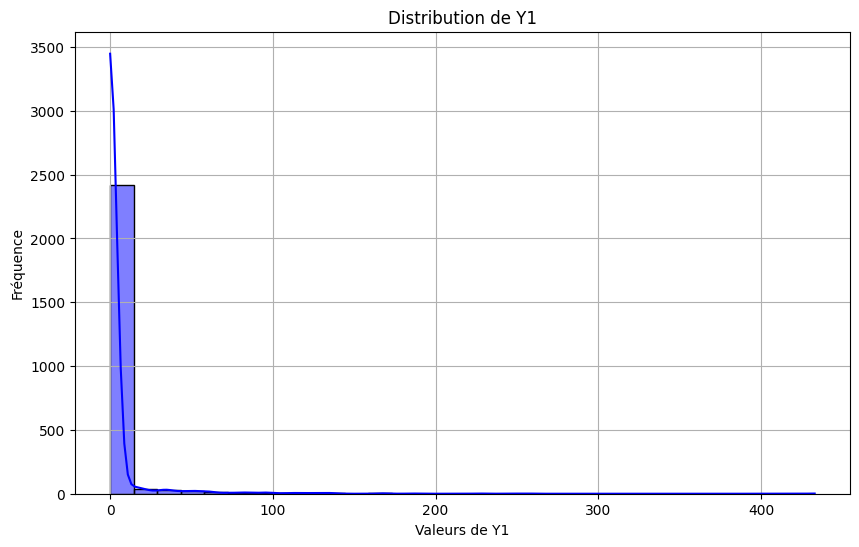

In [4]:
summarize_target(y)
plot_target_distribution(y)

## Determination du seuil optimal  et Entrainement pour Random Forest

In [5]:
param_grid_rf={
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5]
}

## Determination du seuil optimal pour Bagging

In [6]:
param_grid_bagging = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 10, 20],
    'max_samples': [0.5, 1.0]
}


## Cross Validation et hyperparamètres pour Decision Tree

In [7]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

## Cross Validation et hyperparamètres pour Extra Trees

In [8]:
param_grid_et = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [9]:
models_and_params = [
    (RandomForestClassifier(), param_grid_rf),
    (BaggingClassifier(DecisionTreeClassifier()), param_grid_bagging),
    (DecisionTreeClassifier(), param_grid_dt),
    (ExtraTreesClassifier(n_estimators=100), param_grid_et)
]

best_model_result = train_multiple_models_with_mlflow(X_scaled, y, models_and_params)
print(best_model_result['model_name'], best_model_result['f1_score'])
print(best_model_result['classification_report'])

Training RandomForestClassifier...


2025/07/18 15:32:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 15:33:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier F1 score: 0.7158
Training BaggingClassifier...


2025/07/18 15:33:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 15:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


BaggingClassifier F1 score: 0.7129
Training DecisionTreeClassifier...


2025/07/18 15:33:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 15:33:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTreeClassifier F1 score: 0.6667
Training ExtraTreesClassifier...


2025/07/18 15:34:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/18 15:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ExtraTreesClassifier F1 score: 0.7255
ExtraTreesClassifier 0.7254901960784315
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       458
           1       0.77      0.69      0.73        54

    accuracy                           0.95       512
   macro avg       0.87      0.83      0.85       512
weighted avg       0.94      0.95      0.94       512



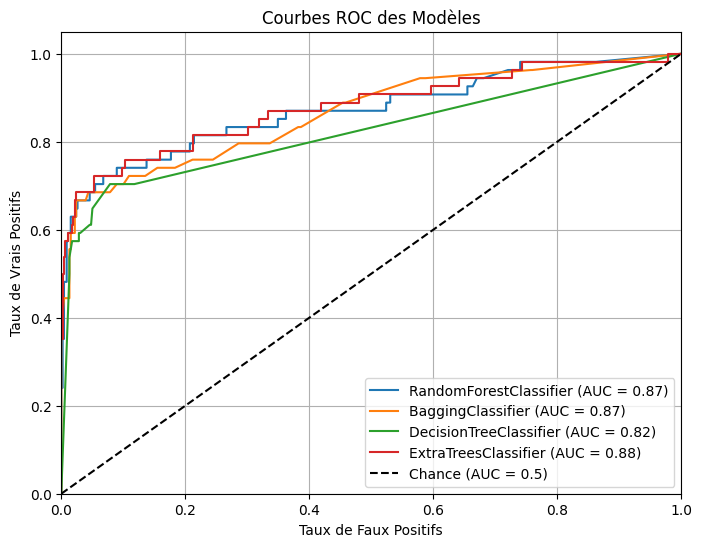

In [10]:
plot_roc_curve(best_model_result["y_test"], best_model_result["model_probs"])

In [14]:
os.makedirs("models", exist_ok=True)
model_path = f"models/{best_model_result['model_name']}_best_model.pkl"
joblib.dump(best_model_result["best_model"], model_path)
print(f"Modèle sauvegardé dans {model_path}")

Modèle sauvegardé dans models/ExtraTreesClassifier_best_model.pkl
